<a href="https://colab.research.google.com/github/LatiefDataVisionary/multivariate-analysis-college-task/blob/main/src/DiscriminantAnalysis_week12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

Pada bagian ini, dilakukan impor terhadap pustaka-pustaka (libraries) Python yang esensial untuk analisis data, manipulasi data, pemodelan machine learning, dan visualisasi.

*   **Pandas**: Digunakan untuk manipulasi dan analisis data, khususnya untuk bekerja dengan struktur data DataFrame yang tabular.
*   **NumPy**: Merupakan pustaka fundamental untuk komputasi numerik di Python, menyediakan dukungan untuk array dan matriks multidimensi, beserta kumpulan fungsi matematika tingkat tinggi untuk beroperasi pada array tersebut.
*   **Scikit-learn (sklearn)**: Pustaka machine learning yang komprehensif. Dari sini, akan diimpor beberapa modul spesifik:
    *   `train_test_split`: Untuk membagi dataset menjadi set pelatihan dan pengujian.
    *   `LinearDiscriminantAnalysis`: Implementasi dari model Analisis Diskriminan Linier.
    *   `StandardScaler`: Untuk melakukan standarisasi fitur (opsional, tetapi seringkali bermanfaat).
    *   `accuracy_score`, `confusion_matrix`, `classification_report`: Metrik untuk mengevaluasi performa model klasifikasi.
*   **Matplotlib.pyplot** dan **Seaborn**: Digunakan untuk membuat visualisasi data statis, animasi, dan interaktif. (Meskipun mungkin tidak selalu digunakan secara ekstensif dalam LDA dasar, ada baiknya untuk diimpor jika diperlukan eksplorasi atau visualisasi hasil).
*   **KaggleHub** dan **OS**: Digunakan spesifik untuk mengunduh dan mengakses dataset dari Kaggle, sesuai dengan instruksi pemuatan data yang diberikan.

## **1. Load Dataset**

In [19]:
path = 'https://raw.githubusercontent.com/LatiefDataVisionary/multivariate-analysis-college-task/refs/heads/main/datasets/dataset_LDA_2clusters.csv'

df = pd.read_csv(path)
df.head()

,BloodPressure,Age,Cluster
0,72,50,0
1,66,31,1
2,64,32,1
3,66,21,1
4,40,33,1


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   BloodPressure  600 non-null    int64
 1   Age            600 non-null    int64
 2   Cluster        600 non-null    int64
dtypes: int64(3)
memory usage: 14.2 KB


In [21]:
df.describe()

,BloodPressure,Age,Cluster
count,600.000000,600.000000,600.000000
mean,72.041667,33.278333,0.651667
std,11.980086,11.822315,0.476840
min,24.000000,21.000000,0.000000
25%,64.000000,24.000000,0.000000
50%,72.000000,29.000000,1.000000
75%,80.000000,40.000000,1.000000
max,122.000000,81.000000,1.000000


In [22]:
df.shape

(600, 3)

## **2. Data Preprocessing and Preparation**

Tahap pra-pemrosesan data adalah langkah krusial sebelum membangun model machine learning. Tujuannya adalah untuk menyiapkan data dalam format yang sesuai untuk algoritma LDA.


1.  **Memisahkan Fitur (Variabel Independen) dan Target (Variabel Dependen)**:
    *   Variabel independen (fitur) adalah kolom-kolom yang akan digunakan untuk membuat prediksi. Dalam kasus ini, fitur adalah `BloodPressure` dan `Age`. Variabel-variabel ini akan disimpan dalam DataFrame `X`.
    *   Variabel dependen (target) adalah kolom yang ingin diprediksi. Dalam kasus ini, target adalah kolom `Cluster`. Variabel ini akan disimpan dalam Series `y`.
2.  **Membagi Data menjadi Set Pelatihan dan Pengujian (`train_test_split`)**:
    *   Dataset akan dibagi menjadi dua subset: set pelatihan (`X_train`, `y_train`) dan set pengujian (`X_test`, `y_test`).
    *   Model akan dilatih menggunakan set pelatihan.
    *   Performa model akan dievaluasi menggunakan set pengujian, yang merupakan data yang belum pernah dilihat oleh model selama proses pelatihan.
    *   Parameter `test_size=0.3` menunjukkan bahwa 30% dari data akan dialokasikan untuk set pengujian, dan sisanya (70%) untuk set pelatihan.
    *   Parameter `random_state=42` digunakan untuk memastikan bahwa pembagian data bersifat reproduktif. Artinya, jika kode dijalankan kembali dengan `random_state` yang sama, pembagian datanya akan selalu sama. Ini penting untuk konsistensi hasil.
3.  **Penskalaan Fitur (`StandardScaler`) (Opsional namun Direkomendasikan)**:
    *   LDA sensitif terhadap skala fitur, karena ia mencoba untuk memaksimalkan jarak antar kelas. Fitur dengan skala yang lebih besar mungkin mendominasi perhitungan jarak.
    *   `StandardScaler` dari scikit-learn digunakan untuk melakukan standarisasi fitur dengan menghilangkan mean dan menskalakan ke varians unit.
    *   Prosesnya adalah:
        *   Menginisialisasi objek `StandardScaler`.
        *   Melatih (fit) scaler **hanya** pada data fitur pelatihan (`X_train`). Ini penting untuk menghindari kebocoran data (data leakage) dari set pengujian ke proses pelatihan scaler.
        *   Mengaplikasikan (transform) penskalaan yang telah dipelajari ke data fitur pelatihan (`X_train`) dan data fitur pengujian (`X_test`).
    *   Setelah penskalaan, semua fitur akan memiliki mean sekitar 0 dan standar deviasi sekitar 1.

In [23]:
# Memastikan tidak ada nilai NaN di kolom yang akan digunakan
# Jika ada, perlu strategi penanganan (misal, imputasi atau penghapusan baris)
print("Missing values before any processing:")
print(df.isnull().sum())

Missing values before any processing:
BloodPressure    0
Age              0
Cluster          0
dtype: int64


In [24]:
# Jika ada NaN pada fitur atau target, dan ingin menghapus barisnya:
# df.dropna(subset=['BloodPressure', 'Age', 'Cluster'], inplace=True)
# print("\nMissing values after dropping NaN rows (if any):")
# print(df.isnull().sum())
# print("\nNew dataset shape after dropping NaN rows:", df.shape)

### **2.1. Memisahkan Fitur (X) dan Target (y)**

In [31]:
feature_columns = ['BloodPressure', 'Age']
target_column = 'Cluster'

X = df[feature_columns]
y = df[target_column]

print("\nShape of features (X):", X.shape)
print("Shape of target (y):", y.shape)
print("\nFirst 5 rows of features (X):")
print(X.head(10))
print("\nFirst 5 values of target (y):")
print(y.head(10))


Shape of features (X): (600, 2)
Shape of target (y): (600,)

First 5 rows of features (X):
   BloodPressure  Age
0             72   50
1             66   31
2             64   32
3             66   21
4             40   33
5             74   30
6             50   26
7             72   29
8             70   53
9             96   54

First 5 values of target (y):
0    0
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    0
9    0
Name: Cluster, dtype: int64


### **2.2. Membagi Data menjadi Set Pelatihan dan Pengujian**


In [33]:
# Umumnya menggunakan 70-80% untuk pelatihan dan 20-30% untuk pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# stratify=y digunakan untuk memastikan proporsi kelas target sama di train dan test set, penting untuk klasifikasi

In [35]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (420, 2)
Shape of X_test: (180, 2)
Shape of y_train: (420,)
Shape of y_test: (180,)


In [36]:
print("\nProportion of target variable in original dataset:")
print(y.value_counts(normalize=True))
print("\nProportion of target variable in training set:")
print(y_train.value_counts(normalize=True))
print("\nProportion of target variable in test set:")
print(y_test.value_counts(normalize=True))


Proportion of target variable in original dataset:
Cluster
1    0.651667
0    0.348333
Name: proportion, dtype: float64

Proportion of target variable in training set:
Cluster
1    0.652381
0    0.347619
Name: proportion, dtype: float64

Proportion of target variable in test set:
Cluster
1    0.65
0    0.35
Name: proportion, dtype: float64


### **2.3. Penskalaan Fitur (Feature Scaling)**


In [38]:
# Inisialisasi StandardScaler
scaler = StandardScaler()

# Fit scaler pada data pelatihan dan transformasikan data pelatihan
X_train_scaled = scaler.fit_transform(X_train)

# Transformasikan data pengujian menggunakan scaler yang sudah di-fit pada data pelatihan
X_test_scaled = scaler.transform(X_test)

# Mengubah hasil scaling kembali menjadi DataFrame Pandas (opsional, untuk kemudahan inspeksi)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_columns)

print("First 5 rows of scaled training features (X_train_scaled_df):")
print(X_train_scaled_df.head())
print("\nDescriptive statistics of scaled training features:")
print(X_train_scaled_df.describe().round(2)) # .round(2) untuk membulatkan agar mudah dibaca
print("\nFirst 5 rows of scaled test features (X_test_scaled_df):")
print(X_test_scaled_df.head())

First 5 rows of scaled training features (X_train_scaled_df):
   BloodPressure       Age
0      -0.002763 -0.774024
1      -0.334348 -0.689673
2       0.328822 -0.605321
3      -0.168556 -0.689673
4       0.163029  0.659949

Descriptive statistics of scaled training features:
       BloodPressure     Age
count         420.00  420.00
mean            0.00   -0.00
std             1.00    1.00
min            -3.98   -1.03
25%            -0.67   -0.77
50%            -0.00   -0.35
75%             0.49    0.58
max             4.14    4.03

First 5 rows of scaled test features (X_test_scaled_df):
   BloodPressure       Age
0      -0.665933 -1.027078
1      -0.831725  0.153841
2      -0.168556  0.322544
3      -0.334348 -0.267916
4       0.494614  1.081706


**Poin Penting:**
- **Penanganan Missing value**:
  - Untuk dataset `dataset_LDA_2clusters.csv` yang diberikan, ternyata tidak ada nilai yang hilang, tetapi ini adalah praktik standar yang baik.
- **`stratify=y`**:
  - Saat melakukan `train_test_split`, `stratify=y` sangat penting untuk masalah klasifikasi, terutama jika distribusi kelas tidak seimbang. Ini memastikan bahwa proporsi setiap kelas dalam variabel target (y) dipertahankan baik di set pelatihan maupun di set pengujian.
- **Fitting Scaler**:
  - `StandardScaler` (atau scaler lainnya) selalu di-fit hanya pada data pelatihan (`X_train`) dan kemudian digunakan untuk mentransformasi baik data pelatihan (`X_train`) maupun data pengujian (`X_test`). Ini mencegah kebocoran informasi dari data pengujian ke dalam proses pelatihan model (atau pra-pemrosesan).

Setelah langkah-langkah ini, data `X_train_scaled`, `X_test_scaled`, `y_train`, dan `y_test` siap digunakan untuk membangun dan mengevaluasi model LDA.


## **3. Model Building: Linear Discriminant Analysis (LDA)**


Setelah data disiapkan dan diproses, langkah selanjutnya adalah membangun model Analisis Diskriminan Linier (LDA).

1.  **Menginisialisasi Model LDA**:
    *   Sebuah instance dari kelas `LinearDiscriminantAnalysis` dari `sklearn.discriminant_analysis` dibuat.
    *   Untuk kasus klasifikasi biner (dua kelompok/cluster seperti dalam dataset ini), LDA secara default akan menghasilkan satu komponen diskriminan (`n_components = min(n_features, n_classes - 1)`). Jika ada 2 fitur dan 2 kelas, maka akan ada `min(2, 2-1) = 1` komponen diskriminan. Parameter `n_components` dapat diatur secara eksplisit jika LDA juga ingin digunakan untuk reduksi dimensi menjadi jumlah komponen yang lebih sedikit dari defaultnya, namun untuk klasifikasi saja, pengaturan default biasanya sudah cukup.
2.  **Melatih Model LDA**:
    *   Model LDA yang telah diinisialisasi kemudian dilatih (di-"fit") menggunakan data fitur pelatihan yang telah diskalakan (`X_train_scaled`) dan variabel target pelatihan (`y_train`).
    *   Selama proses `fit`, model LDA akan mempelajari parameter-parameter (koefisien dan intercept) yang paling baik untuk memisahkan antar kelas berdasarkan data pelatihan. Ini melibatkan perhitungan rata-rata kelas, matriks kovarians dalam kelas, dan matriks kovarians antar kelas untuk menemukan proyeksi yang memaksimalkan separabilitas kelas.

### **3.1. Menginisialisasi model LDA**

Untuk klasifikasi, `n_components` tidak perlu diatur secara eksplisit jika jumlahnya kurang dari `n_classes-1`. Namun, jika ingin menggunakan LDA untuk reduksi dimensi, parameter `n_components` bisa diatur. Dalam kasus ini, dengan 2 kelas, akan ada `n_classes - 1 = 1 `komponen diskriminan.

In [41]:
lda_model = LinearDiscriminantAnalysis(n_components=1) # Bisa juga: LinearDiscriminantAnalysis()

### **3.2. Melatih model LDA menggunakan data pelatihan yang sudah diskalakan**

In [43]:
lda_model.fit(X_train_scaled, y_train)

print(f"Number of discriminant components learned: {lda_model.n_components}")

Number of discriminant components learned: 1


## **4. Model Evaluation**


Setelah model LDA berhasil dilatih, langkah selanjutnya adalah mengevaluasi performanya menggunakan data pengujian. Evaluasi ini memberikan gambaran seberapa baik model dapat menggeneralisasi kemampuannya pada data baru.

1.  **Membuat Prediksi pada Data Pengujian**:
    *   Metode `predict()` dari model LDA yang telah dilatih (`lda_model`) digunakan untuk membuat prediksi kelas pada data fitur pengujian yang telah diskalakan (`X_test_scaled`).
    *   Hasil prediksi ini (`y_pred`) akan dibandingkan dengan nilai target sebenarnya dari data pengujian (`y_test`).
2.  **Menghitung Akurasi (`accuracy_score`)**:
    *   Akurasi adalah metrik paling sederhana yang mengukur proporsi prediksi yang benar dari total jumlah prediksi.
    *   `accuracy_score(y_test, y_pred)` menghitung nilai akurasi.
3.  **Menampilkan Confusion Matrix (`confusion_matrix`)**:
    *   Confusion matrix adalah tabel yang merangkum performa model klasifikasi. Untuk klasifikasi biner, tabelnya berukuran 2x2:
        *   **True Positives (TP)**: Jumlah observasi positif yang diprediksi dengan benar sebagai positif.
        *   **True Negatives (TN)**: Jumlah observasi negatif yang diprediksi dengan benar sebagai negatif.
        *   **False Positives (FP) / Type I Error**: Jumlah observasi negatif yang salah diprediksi sebagai positif.
        *   **False Negatives (FN) / Type II Error**: Jumlah observasi positif yang salah diprediksi sebagai negatif.
    *   `confusion_matrix(y_test, y_pred)` menghasilkan matriks ini.
    *   Visualisasi confusion matrix menggunakan `seaborn.heatmap` dapat membuatnya lebih mudah dibaca dan diinterpretasikan.
4.  **Menampilkan Laporan Klasifikasi (`classification_report`)**:
    *   Laporan klasifikasi memberikan metrik evaluasi yang lebih detail per kelas, termasuk:
        *   **Precision**: Kemampuan model untuk tidak memberi label positif pada sampel yang sebenarnya negatif (`TP / (TP + FP)`).
        *   **Recall (Sensitivity)**: Kemampuan model untuk menemukan semua sampel positif (`TP / (TP + FN)`).
        *   **F1-score**: Rata-rata harmonik dari precision dan recall (`2 * (Precision * Recall) / (Precision + Recall)`). Ini berguna ketika ada ketidakseimbangan kelas.
        *   **Support**: Jumlah aktual kemunculan setiap kelas dalam `y_test`.
    *   `classification_report(y_test, y_pred)` menghasilkan laporan ini.

Metrik-metrik ini secara kolektif memberikan pemahaman yang komprehensif tentang seberapa baik model LDA melakukan tugas klasifikasi pada data pengujian.

### **4.1. Membuat prediksi pada data pengujian**

In [44]:
# X_test_scaled didapatkan dari langkah pra-pemrosesan sebelumnya
y_pred = lda_model.predict(X_test_scaled)

### **4.2. Menghitung Akurasi**

In [45]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the LDA model: {accuracy:.4f}")
print(f"Accuracy in percentage: {accuracy*100:.2f}%")

Accuracy of the LDA model: 0.9833
Accuracy in percentage: 98.33%


### **4.3. Menampilkan Confusion Matrix**

In [46]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 60   3]
 [  0 117]]


Visualisasi Confusion Matrix


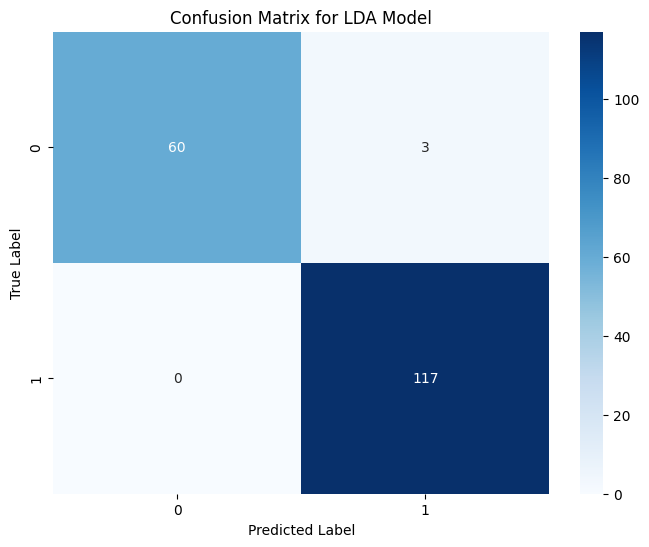

In [47]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=lda_model.classes_, yticklabels=lda_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for LDA Model')
plt.show()

### **4.4. Menampilkan Laporan Klasifikasi**

In [48]:
class_report = classification_report(y_test, y_pred, target_names=[f'Cluster {cls}' for cls in lda_model.classes_])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

   Cluster 0       1.00      0.95      0.98        63
   Cluster 1       0.97      1.00      0.99       117

    accuracy                           0.98       180
   macro avg       0.99      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



### **5. Extracting Discriminant Function Coefficients**


Model Analisis Diskriminan Linier (LDA) yang telah dilatih menghasilkan sebuah fungsi (atau beberapa fungsi, tergantung jumlah kelas dan fitur) yang digunakan untuk memproyeksikan data ke ruang berdimensi lebih rendah yang memaksimalkan separabilitas antar kelas. Untuk kasus klasifikasi biner dengan dua fitur, akan ada satu fungsi diskriminan linier.

Fungsi diskriminan ini memiliki bentuk:
`LD = coef₁ * Feature₁_scaled + coef₂ * Feature₂_scaled + ... + intercept`

Atau, jika hanya ada satu fungsi diskriminan (kasus biner), nilai batas keputusan (threshold) seringkali diasumsikan 0 pada sumbu diskriminan ini. Skor diskriminan (`LD_score`) untuk setiap observasi dapat dihitung, dan kemudian diklasifikasikan berdasarkan apakah skor tersebut di atas atau di bawah threshold.

1.  **Mengekstrak Koefisien (`lda_model.coef_`)**:
    *   Atribut `coef_` pada objek model LDA yang telah dilatih berisi bobot (koefisien) untuk setiap fitur.
    *   Untuk klasifikasi biner, `lda_model.coef_` akan menghasilkan array 2D dengan satu baris (karena hanya ada satu fungsi diskriminan) dan sejumlah kolom yang sama dengan jumlah fitur. Setiap nilai dalam baris tersebut adalah koefisien untuk fitur yang bersesuaian.
    *   Koefisien ini menunjukkan kontribusi relatif dari setiap fitur (yang telah diskalakan) terhadap skor fungsi diskriminan. Tanda (positif atau negatif) dari koefisien menunjukkan arah hubungan fitur dengan skor diskriminan.
2.  **Mengekstrak Intercept (`lda_model.intercept_`)**:
    *   Atribut `intercept_` pada objek model LDA berisi nilai konstanta (bias) dari fungsi diskriminan.
    *   Untuk klasifikasi biner, ini adalah array 1D dengan satu elemen.
3.  **Menyajikan Fungsi Diskriminan**:
    *   Dengan koefisien dan intercept yang telah diekstrak, fungsi diskriminan linier dapat dituliskan secara eksplisit.
    *   Penting untuk diingat bahwa koefisien ini berlaku untuk fitur yang **telah diskalakan** (jika penskalaan dilakukan sebelumnya, seperti `StandardScaler`).

Memahami koefisien ini dapat memberikan wawasan tentang fitur mana yang paling penting dalam membedakan antar kelas menurut model LDA.

### **5.1. Mengekstrak Koefisien**


In [49]:
# lda_model.coef_ adalah array 2D, untuk klasifikasi biner, ini akan menjadi (1, n_features)
coefficients = lda_model.coef_[0] # Ambil baris pertama karena hanya ada 1 fungsi diskriminan

Membuat Series Pandas untuk menampilkan koefisien dengan nama fitur

In [50]:
coeffs_df = pd.DataFrame(coefficients, index=feature_columns, columns=['Coefficient'])
print("Discriminant Function Coefficients (for scaled features):")
print(coeffs_df)

Discriminant Function Coefficients (for scaled features):
               Coefficient
BloodPressure    -1.939921
Age              -4.606589


### **5.2. Mengekstrak Intercept**

In [51]:
intercept = lda_model.intercept_[0] # Intercept juga array, ambil elemen pertamanya
print(f"Intercept of the Discriminant Function: {intercept:.4f}")

Intercept of the Discriminant Function: 2.0805


### **5.3. Menyajikan Fungsi Diskriminan Linier**

In [52]:
# Fungsi: LD_score = (Coefficient_BP * Scaled_BloodPressure) + (Coefficient_Age * Scaled_Age) + Intercept
# Klasifikasi: Jika LD_score > 0, prediksi kelas 1 (atau kelas dengan label lebih tinggi), jika < 0, prediksi kelas 0 (atau kelas dengan label lebih rendah).
# (Catatan: Scikit-learn menangani ambang batasnya secara internal berdasarkan nilai output dari lda_model.decision_function())

function_string = f"LD_Score = ({coefficients[0]:.4f} * Scaled_BloodPressure) + ({coefficients[1]:.4f} * Scaled_Age) + ({intercept:.4f})"
print("Linear Discriminant Function:")
print(function_string)

Linear Discriminant Function:
LD_Score = (-1.9399 * Scaled_BloodPressure) + (-4.6066 * Scaled_Age) + (2.0805)


In [53]:
print("\nPenjelasan Fungsi:")
print("Klasifikasi umumnya dilakukan berdasarkan tanda dari LD_Score:")
print(f"  - Jika LD_Score > 0, observasi cenderung diklasifikasikan sebagai Cluster {lda_model.classes_[1]}.") # Asumsi kelas 1 adalah kelas "positif"
print(f"  - Jika LD_Score < 0, observasi cenderung diklasifikasikan sebagai Cluster {lda_model.classes_[0]}.") # Asumsi kelas 0 adalah kelas "negatif"
print("(Ambang batas sebenarnya yang digunakan oleh `predict` bisa sedikit berbeda dari 0 ketat, namun ini adalah interpretasi umumnya).")

# Verifikasi manual dengan decision_function untuk satu sampel
# Ambil satu sampel dari X_test_scaled
sample_scaled = X_test_scaled[0]
manual_ld_score = np.dot(sample_scaled, coefficients) + intercept
sklearn_decision_value = lda_model.decision_function(sample_scaled.reshape(1, -1))[0]
predicted_class_for_sample = lda_model.predict(sample_scaled.reshape(1, -1))[0]


print(f"\nContoh perhitungan untuk sampel pertama dari X_test_scaled:")
print(f"  Scaled_BloodPressure: {sample_scaled[0]:.4f}, Scaled_Age: {sample_scaled[1]:.4f}")
print(f"  Manual LD_Score calculated: ({coefficients[0]:.4f} * {sample_scaled[0]:.4f}) + ({coefficients[1]:.4f} * {sample_scaled[1]:.4f}) + ({intercept:.4f}) = {manual_ld_score:.4f}")
print(f"  Scikit-learn decision_function value: {sklearn_decision_value:.4f}")
print(f"  Predicted class by lda_model.predict(): Cluster {predicted_class_for_sample}")
print(f"  Actual class for this sample (from y_test): Cluster {y_test.iloc[0]}")


Penjelasan Fungsi:
Klasifikasi umumnya dilakukan berdasarkan tanda dari LD_Score:
  - Jika LD_Score > 0, observasi cenderung diklasifikasikan sebagai Cluster 1.
  - Jika LD_Score < 0, observasi cenderung diklasifikasikan sebagai Cluster 0.
(Ambang batas sebenarnya yang digunakan oleh `predict` bisa sedikit berbeda dari 0 ketat, namun ini adalah interpretasi umumnya).

Contoh perhitungan untuk sampel pertama dari X_test_scaled:
  Scaled_BloodPressure: -0.6659, Scaled_Age: -1.0271
  Manual LD_Score calculated: (-1.9399 * -0.6659) + (-4.6066 * -1.0271) + (2.0805) = 8.1037
  Scikit-learn decision_function value: 8.1037
  Predicted class by lda_model.predict(): Cluster 1
  Actual class for this sample (from y_test): Cluster 1


### **6. Visualization**

Visualisasi dapat memberikan pemahaman intuitif tentang bagaimana model LDA bekerja dan bagaimana data dipisahkan.

1.  **Distribusi Fitur per Kelas**:
    *   Membuat histogram atau density plot untuk setiap fitur (`BloodPressure` dan `Age`), yang diwarnai berdasarkan kelas (`Cluster`). Ini membantu untuk melihat apakah ada perbedaan distribusi yang jelas antara dua kelas untuk masing-masing fitur.
2.  **Scatter Plot Fitur Asli dengan Batas Keputusan LDA**:
    *   Karena kita memiliki dua fitur, data asli (sebelum atau sesudah penskalaan) dapat divisualisasikan dalam scatter plot 2D.
    *   Batas keputusan (decision boundary) yang dipelajari oleh LDA dapat digambarkan sebagai garis pada plot ini. Garis ini memisahkan area di mana model akan memprediksi Kelas 0 dari area di mana ia akan memprediksi Kelas 1.
    *   Untuk mendapatkan garis batas keputusan, kita bisa menggunakan koefisien dan intercept dari model LDA. Batas keputusan adalah tempat di mana fungsi diskriminan (atau `decision_function`) sama dengan nol.
        `coef₁ * x₁_scaled + coef₂ * x₂_scaled + intercept = 0`
        Jika kita menggunakan data yang diskalakan, `x₁_scaled` dan `x₂_scaled` adalah variabelnya. Kita bisa mengekspresikan salah satu variabel dalam bentuk yang lain untuk menggambar garisnya. Misal, `x₂_scaled = (-coef₁ * x₁_scaled - intercept) / coef₂`. Kemudian, nilai-nilai `x₁_scaled` dan `x₂_scaled` ini perlu di-transformasikan kembali ke skala fitur asli jika kita ingin menggambar batas keputusan pada plot fitur asli.
3.  **Distribusi Skor Diskriminan (LD Scores)**:
    *   Model LDA memproyeksikan data ke satu sumbu diskriminan (karena ini adalah masalah klasifikasi biner). Kita bisa menghitung skor diskriminan (proyeksi) untuk setiap titik data pada sumbu ini.
    *   Membuat histogram atau density plot dari skor diskriminan ini, yang diwarnai berdasarkan kelas aktual, dapat menunjukkan seberapa baik sumbu diskriminan tersebut memisahkan kedua kelas. Idealnya, distribusi skor untuk kedua kelas akan memiliki tumpang tindih (overlap) yang minimal.
    *   Skor ini bisa didapatkan dari `lda_model.transform(X_scaled)`.

Visualisasi ini membantu dalam interpretasi model dan identifikasi apakah asumsi LDA (seperti distribusi normal dan kesamaan kovarians) mungkin terpenuhi secara kasar.

### **6.1. Distribusi Fitur per Kelas**

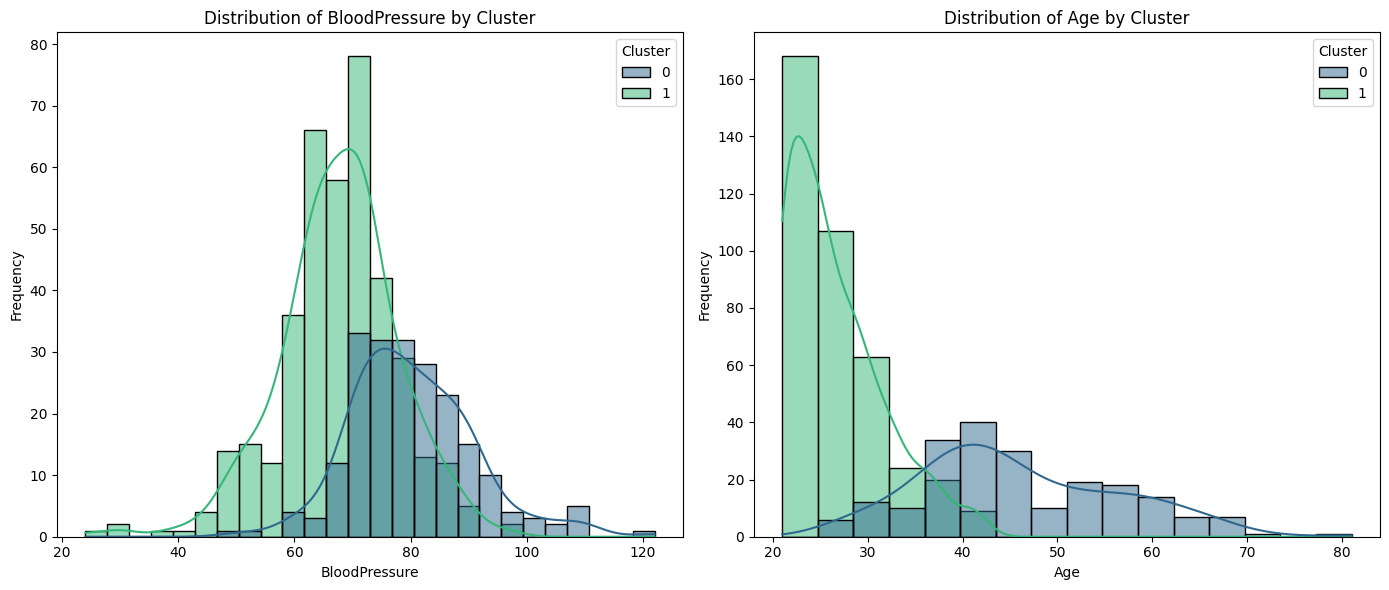

In [54]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='BloodPressure', hue='Cluster', kde=True, palette='viridis')
plt.title('Distribution of BloodPressure by Cluster')
plt.xlabel('BloodPressure')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='Age', hue='Cluster', kde=True, palette='viridis')
plt.title('Distribution of Age by Cluster')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### **6.2. Scatter Plot Fitur (Scaled) dengan Batas Keputusan LDA**

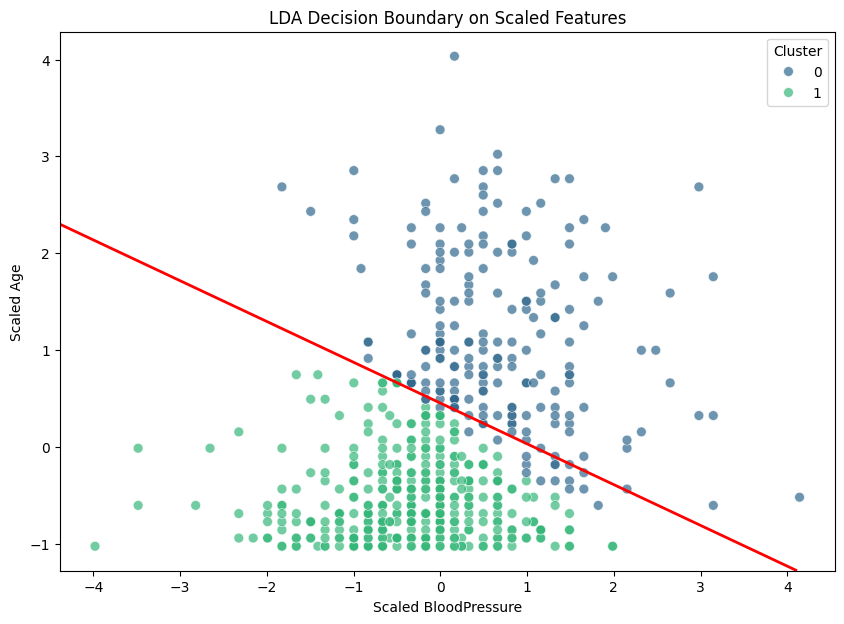

In [55]:
# Kita akan menggunakan data yang diskalakan karena model dilatih padanya.
# Ambil koefisien dan intercept dari model LDA
coef = lda_model.coef_[0]
intercept = lda_model.intercept_[0]

# Membuat meshgrid untuk plot batas keputusan
# Kita perlu menentukan rentang untuk x1_scaled (BloodPressure_scaled)
# dan kemudian hitung x2_scaled (Age_scaled) berdasarkan persamaan batas keputusan.
# Persamaan batas: coef[0]*x1_s + coef[1]*x2_s + intercept = 0
# Maka, x2_s = (-coef[0]*x1_s - intercept) / coef[1]

# Plot data yang diskalakan dari set pelatihan (atau bisa juga keseluruhan data yang diskalakan)
X_scaled_df = pd.DataFrame(scaler.transform(X), columns=feature_columns) # Skalakan seluruh X
X_scaled_df['Cluster'] = y.values # Tambahkan kolom cluster untuk pewarnaan

plt.figure(figsize=(10, 7))
sns.scatterplot(data=X_scaled_df, x='BloodPressure', y='Age', hue='Cluster', palette='viridis', s=50, alpha=0.7)
plt.title('LDA Decision Boundary on Scaled Features')
plt.xlabel('Scaled BloodPressure')
plt.ylabel('Scaled Age')

# Menyiapkan titik-titik untuk garis batas keputusan
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Buat meshgrid (alternatif: cukup plot garisnya saja)
xx = np.linspace(xlim[0], xlim[1], 100)
yy = np.linspace(ylim[0], ylim[1], 100)
XX, YY = np.meshgrid(xx, yy)
Z = lda_model.decision_function(np.c_[XX.ravel(), YY.ravel()])
Z = Z.reshape(XX.shape)

# Plot batas keputusan (contour di mana decision_function == 0)
plt.contour(XX, YY, Z, levels=[0], linewidths=2, colors='red')
plt.legend(title='Cluster')
plt.show()

### **6.3. Distribusi Skor Diskriminan (LD Scores)**

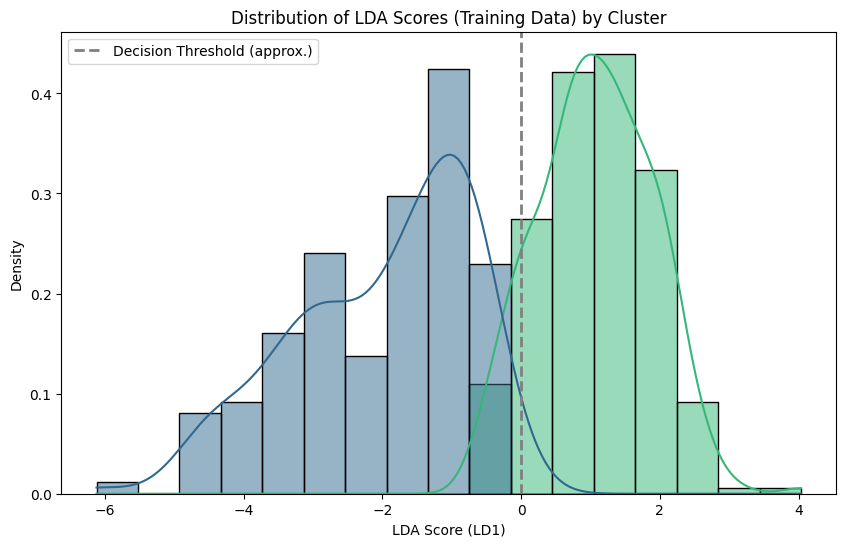

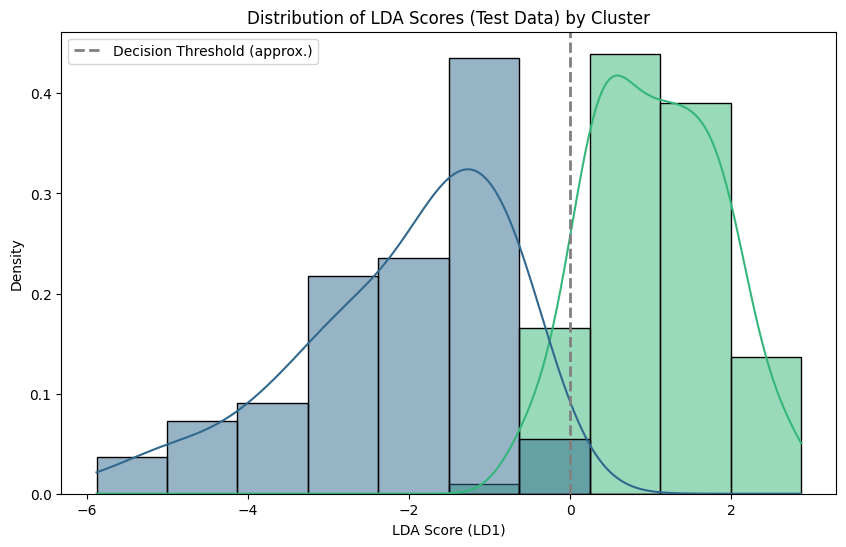

In [56]:
# Transformasikan data fitur yang diskalakan (misalnya, X_train_scaled atau X_test_scaled) ke komponen diskriminan
# Karena n_components=1, hasilnya akan menjadi array 1D.
X_lda_train = lda_model.transform(X_train_scaled)
X_lda_test = lda_model.transform(X_test_scaled) # Atau gunakan seluruh data jika diinginkan

# Membuat DataFrame untuk kemudahan plotting dengan Seaborn
df_lda_scores_train = pd.DataFrame({'LD1_Score': X_lda_train[:, 0], 'Cluster': y_train})
df_lda_scores_test = pd.DataFrame({'LD1_Score': X_lda_test[:, 0], 'Cluster': y_test})

plt.figure(figsize=(10, 6))
sns.histplot(data=df_lda_scores_train, x='LD1_Score', hue='Cluster', kde=True, palette='viridis', stat="density", common_norm=False)
plt.title('Distribution of LDA Scores (Training Data) by Cluster')
plt.xlabel('LDA Score (LD1)')
plt.ylabel('Density')
plt.axvline(0, color='grey', linestyle='--', lw=2, label='Decision Threshold (approx.)') # Ambang batas umumnya 0
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=df_lda_scores_test, x='LD1_Score', hue='Cluster', kde=True, palette='viridis', stat="density", common_norm=False)
plt.title('Distribution of LDA Scores (Test Data) by Cluster')
plt.xlabel('LDA Score (LD1)')
plt.ylabel('Density')
plt.axvline(0, color='grey', linestyle='--', lw=2, label='Decision Threshold (approx.)')
plt.legend()
plt.show()

## **7. Making Predictions on New Data**

Setelah model LDA dilatih dan dievaluasi, model tersebut dapat digunakan untuk membuat prediksi pada data baru yang belum pernah dilihat sebelumnya dan tidak memiliki label kelas.

1.  **Menyiapkan Data Baru**:
    *   Data baru harus memiliki struktur kolom fitur yang sama dengan data yang digunakan untuk melatih model (yaitu, `BloodPressure` dan `Age` dalam kasus ini).
    *   Data baru ini akan dibuat sebagai DataFrame Pandas.
2.  **Menerapkan Penskalaan Fitur**:
    *   Sangat penting untuk menerapkan **transformasi penskalaan yang sama** yang digunakan pada data pelatihan. Ini berarti menggunakan objek `scaler` yang telah di-fit pada `X_train` untuk melakukan `transform` pada data baru.
    *   Jangan melakukan `fit` atau `fit_transform` baru pada data baru, karena ini akan menskalakannya berdasarkan statistik data baru itu sendiri, bukan berdasarkan statistik data pelatihan, yang akan menyebabkan inkonsistensi.
3.  **Membuat Prediksi**:
    *   Metode `predict()` dari `lda_model` digunakan pada data baru yang telah diskalakan untuk mendapatkan prediksi kelas.
    *   Metode `predict_proba()` juga dapat digunakan jika ingin mendapatkan probabilitas keanggotaan kelas untuk setiap sampel data baru. LDA secara inheren adalah model linier dan probabilitasnya diestimasi (biasanya dengan menerapkan fungsi logistik atau softmax pada skor diskriminan).
    *   Metode `decision_function()` dapat digunakan untuk mendapatkan skor mentah pada sumbu diskriminan.

Hasil prediksi ini akan menunjukkan bagaimana model mengklasifikasikan observasi baru berdasarkan pola yang telah dipelajarinya dari data pelatihan.

### **7.1. Menyiapkan Data Baru**

In [57]:
new_data_dict = {
    'BloodPressure': [76, 92, 58, 74, 62, 76, 70, 72, 60, 70],
    'Age': [26, 66, 22, 43, 33, 63, 27, 30, 47, 23]
}
new_df = pd.DataFrame(new_data_dict)

print("New data to predict:")
print(new_df)

New data to predict:
   BloodPressure  Age
0             76   26
1             92   66
2             58   22
3             74   43
4             62   33
5             76   63
6             70   27
7             72   30
8             60   47
9             70   23


### **7.2. Menerapkan Penskalaan Fitur**

In [58]:
# Gunakan scaler yang sudah di-fit pada X_train
# scaler ini sudah diinisialisasi dan di-fit di langkah pra-pemrosesan
new_df_scaled_array = scaler.transform(new_df)

# Untuk kemudahan inspeksi, ubah menjadi DataFrame (opsional)
new_df_scaled = pd.DataFrame(new_df_scaled_array, columns=feature_columns)
print("New data after scaling (using the training set's scaler):")
print(new_df_scaled)

New data after scaling (using the training set's scaler):
   BloodPressure       Age
0       0.328822 -0.605321
1       1.655161  2.768733
2      -1.163310 -0.942727
3       0.163029  0.828652
4      -0.831725 -0.014862
5       0.328822  2.515679
6      -0.168556 -0.520970
7      -0.002763 -0.267916
8      -0.997518  1.166057
9      -0.168556 -0.858375


### **7.3. Membuat Prediksi**

In [59]:
# Menggunakan model LDA yang telah dilatih (lda_model)
new_predictions_class = lda_model.predict(new_df_scaled_array)
new_predictions_proba = lda_model.predict_proba(new_df_scaled_array)
new_decision_scores = lda_model.decision_function(new_df_scaled_array)


# Menambahkan hasil prediksi ke DataFrame data baru untuk kemudahan analisis
new_df['Predicted_Cluster'] = new_predictions_class
new_df['Probability_Cluster_0'] = new_predictions_proba[:, 0] # Probabilitas untuk kelas 0
new_df['Probability_Cluster_1'] = new_predictions_proba[:, 1] # Probabilitas untuk kelas 1
new_df['LD_Score'] = new_decision_scores

print("New data with predictions and probabilities:")
print(new_df)
print("\n" + "="*50 + "\n")

print("Interpretation of results:")
for index, row in new_df.iterrows():
    print(f"Sample {index + 1} (BP: {row['BloodPressure']}, Age: {row['Age']}):")
    print(f"  - Predicted Cluster: {row['Predicted_Cluster']}")
    print(f"  - Probability for Cluster 0: {row['Probability_Cluster_0']:.4f}")
    print(f"  - Probability for Cluster 1: {row['Probability_Cluster_1']:.4f}")
    print(f"  - Raw LDA Score (Decision Function): {row['LD_Score']:.4f}\n")


New data with predictions and probabilities:
   BloodPressure  Age  Predicted_Cluster  Probability_Cluster_0  \
0             76   26                  1               0.014328   
1             92   66                  0               0.999999   
2             58   22                  1               0.000170   
3             74   43                  0               0.886251   
4             62   33                  1               0.022699   
5             76   63                  0               0.999961   
6             70   27                  1               0.008103   
7             72   30                  1               0.034889   
8             60   47                  0               0.795096   
9             70   23                  1               0.001723   

   Probability_Cluster_1   LD_Score  
0           9.856718e-01   4.231096  
1           9.330757e-07 -13.884779  
2           9.998301e-01   8.680003  
3           1.137492e-01  -2.053004  
4           9.773007e-01   